# 多层感知机的从零开始实现

In [1]:
import torch
from torch import nn
from d2l import torch as d2l

In [2]:
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

## 初始化模型参数

In [3]:
num_inputs, num_outputs, num_hiddens = 784, 10, 256

In [4]:
W1 = nn.Parameter(torch.randn(num_inputs, num_hiddens, requires_grad=True) * 0.01)
b1 = nn.Parameter(torch.zeros(num_hiddens, requires_grad=True))
W2 = nn.Parameter(torch.randn(num_hiddens, num_outputs, requires_grad=True) * 0.01)
b2 = nn.Parameter(torch.zeros(num_outputs, requires_grad=True))

params = [W1, b1, W2, b2]

## 激活函数

In [5]:
def relu(X):
    a = torch.zeros_like(X)
    return torch.max(X, a)

## 模型

In [8]:
def net(X):
    X = X.reshape((-1, num_inputs))
    H = relu(X@W1 + b1)
    return H@W2 + b2

## 损失函数

In [7]:
loss = nn.CrossEntropyLoss(reduction='none')

## 训练

In [9]:
num_epochs, lr = 10, 0.1
updater = torch.optim.SGD(params, lr=lr)

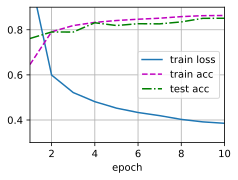

In [10]:
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, updater)

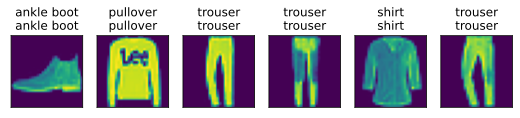

In [11]:
d2l.predict_ch3(net, test_iter)

# 多层感知机的简洁实现

In [12]:
import torch
from torch import nn
from d2l import torch as d2l

## 模型

In [13]:
net = nn.Sequential(nn.Flatten(),
                    nn.Linear(784, 256),
                    nn.ReLU(),
                    nn.Linear(256, 10))

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)
        
net.apply(init_weights)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): ReLU()
  (3): Linear(in_features=256, out_features=10, bias=True)
)

In [14]:
batch_size, lr, num_epochs = 256, 0.1, 10
# 因为前面在设计训练函数时，会将所有样本的损失进行求和再回传
# 所以这里还是保留原始的每个样本损失
loss = nn.CrossEntropyLoss(reduction='none') 
trainer = torch.optim.SGD(net.parameters(), lr=lr)

## 训练

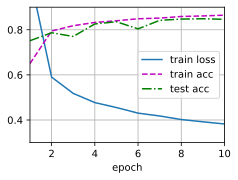

In [15]:
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

## 模型选择、欠拟合和过拟合

当我们⽐较训练和验证误差时，我们要注意两种常⻅的情况。⾸先，我们要注意这样的情况：训练误差和验证误差都很严重，但它们之间仅有⼀点差距。如果模型不能降低训练误差，这可能意味着模型过于简单（即表达能⼒不⾜），⽆法捕获试图学习的模式。此外，由于我们的训练和验证误差之间的泛化误差很⼩，我们有理由相信可以⽤⼀个更复杂的模型降低训练误差。这种现象被称为⽋拟合（underfitting）。

当我们的训练误差明显低于验证误差时要⼩⼼，这表明严重的过拟合（overfitting）。注意，过拟合并不总是⼀件坏事。特别是在深度学习领域，众所周知，最好的预测模型在训练数据上的表现往往⽐在保留（验证）数据上好得多。最终，我们通常更关⼼验证误差，⽽不是训练误差和验证误差之间的差距。

## 多项式回归

通过多项式拟合来探索这些概念

In [16]:
import math
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

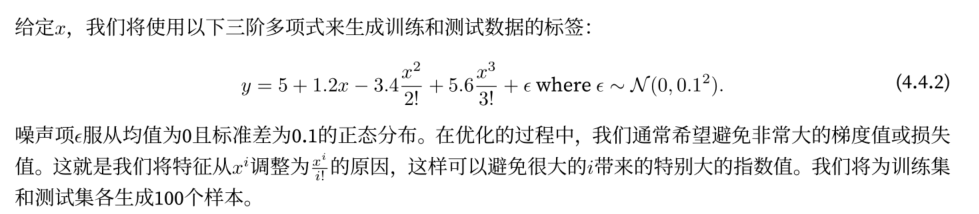

### 生成数据集

In [17]:
max_degree = 20  # 多项式的最大阶数
n_train, n_test = 100, 100  # 训练和测试数据集大小
true_w = np.zeros(max_degree)  # 分配大量的空间
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])

features = np.random.normal(size=(n_train + n_test, 1))
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))  # 平方
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1)  # gamma(n) = (n - 1)!
# labels的维度：(n_train+n_test,)
labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape)

In [18]:
# NumPy ndarray转换为tensor
true_w, features, poly_features, labels = [torch.tensor(x, dtype=torch.float32) 
                                           for x in [true_w, features, poly_features, labels]]

In [19]:
features[:2], poly_features[:2, :], labels[:2]

(tensor([[ 0.0433],
         [-0.0304]]),
 tensor([[ 1.0000e+00,  4.3287e-02,  9.3687e-04,  1.3518e-05,  1.4629e-07,
           1.2665e-09,  9.1368e-12,  5.6501e-14,  3.0572e-16,  1.4704e-18,
           6.3648e-21,  2.5046e-23,  9.0348e-26,  3.0084e-28,  9.3016e-31,
           2.6842e-33,  7.2620e-36,  1.8491e-38,  4.4467e-41,  1.0089e-43],
         [ 1.0000e+00, -3.0355e-02,  4.6070e-04, -4.6615e-06,  3.5375e-08,
          -2.1476e-10,  1.0865e-12, -4.7114e-15,  1.7877e-17, -6.0294e-20,
           1.8302e-22, -5.0505e-25,  1.2776e-27, -2.9831e-30,  6.4679e-33,
          -1.3089e-35,  2.4832e-38, -4.4338e-41,  7.4269e-44, -0.0000e+00]]),
 tensor([5.2236, 4.8663]))

## 对模型进行训练和测试

In [20]:
# 评估模型在给定数据集上的损失
def evaluate_loss(net, data_iter, loss):  #@save
    """评估给定数据集上模型的损失"""
    metric = d2l.Accumulator(2)  # 损失的总和，样本数量
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]

In [21]:
# 定义训练函数
def train(train_features, test_features, train_labels, test_labels, num_epochs=400):
    loss = nn.MSELoss(reduction='none')
    input_shape = train_features.shape[-1]
    # 不设置偏置，因为我们已经在多项式中实现了它
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels.reshape(-1, 1)), batch_size)
    test_iter = d2l.load_array((test_features, test_labels.reshape(-1, 1)), batch_size, is_train=False)
    trainer = torch.optim.SGD(net.parameters(), lr=0.01)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', 
                            yscale='log', xlim=[1, num_epochs], ylim=[1e-3, 1e2],
                            legend=['train', 'test'])
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(net, train_iter, loss),
                                     evaluate_loss(net, test_iter, loss)))
    print('weight:', net[0].weight.data.numpy())

### 正常情况

我们将⾸先使⽤三阶多项式函数，它与数据⽣成函数的阶数相同。结果表明，该模型能有效降低训练损失和测试损失。学习到的模型参数也接近真实值w = [5,1.2,−3.4,5.6]。

weight: [[ 4.9968014  1.1759847 -3.3869977  5.6261597]]


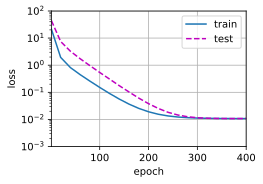

In [22]:
train(poly_features[:n_train, :4], poly_features[n_train:, :4], labels[:n_train], labels[n_train:])

### 欠拟合

再看看线性函数拟合，减少该模型的训练损失相对困难。在最后⼀个迭代周期完成后，训练损失仍然很⾼。当⽤来拟合⾮线性模式（如这⾥的三阶多项式函数）时，线性模型容易⽋拟合。

weight: [[3.5368464 3.61459  ]]


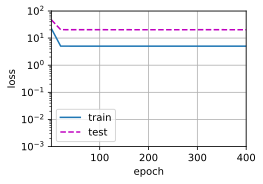

In [23]:
# 从多项式特征中选择前2个维度，即1和x
train(poly_features[:n_train, :2], poly_features[n_train:, :2], labels[:n_train], labels[n_train:])

### 过拟合

尝试使⽤⼀个阶数过⾼的多项式来训练模型。在这种情况下，没有⾜够的数据⽤于学到⾼阶系数应该具有接近于零的值。因此，这个过于复杂的模型会轻易受到训练数据中噪声的影响。虽然训练损失可以有效地降低，但测试损失仍然很⾼。结果表明，复杂模型对数据造成了过拟合。

weight: [[ 4.9899335e+00  1.2519569e+00 -3.3273060e+00  5.1611152e+00
  -3.0114734e-01  1.5310085e+00  6.3773572e-02  5.6982357e-02
   1.5180694e-01 -1.6061942e-01  1.5435787e-01 -5.1890615e-02
   7.6504171e-02 -1.7830151e-01 -1.3083144e-01 -1.9575839e-01
   2.0399282e-03 -1.1690621e-01  2.0840177e-03 -1.5289702e-01]]


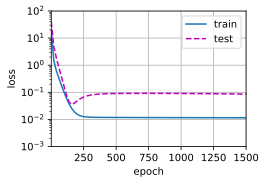

In [24]:
# 从多项式特征中选取所有维度
train(poly_features[:n_train, :],poly_features[n_train:, :], labels[:n_train], labels[n_train:], num_epochs=1500)

那么，出现过拟合的问题，该怎么解决呢？一般而言有两种方法。
1. **收集更多的训练数据**
2. **采用正则化技术**

其中，收集更多的数据，肯定是能缓解过拟合的问题，但是这成本可能很高，耗时颇多，或者完全超出我们的控制，因而在短期内是很难做到的。所以我们一般将重点放在正则化技术上。



# 权重衰减

过拟合在某种程度上来说是，模型过于复杂，学习到了太多的训练数据信息，可以想办法降低模型的复杂度，达到减轻过拟合的现象。

在训练参数化机器学习模型时，权重衰减是最广泛使用的正则化的技术之一，它通常也被称为**$L_2$正则化**。

这项技术通过函数与零的距离来衡量函数的复杂度，因为在所有函数$f$中，函数$f=0$在某种意义上是最简单的。但是我们应该如何精确度量一个函数和零之间的距离呢？

没有一个正确的答案。一个简单的方式是通过线性函数$f(x)=\mathbf{W}^\top x$中的权重向量的某个范数来度量其复杂性，例如$\Vert \mathbf{W} \Vert^2$。要保证权重向量比较小，最常用的方法是将其范数作为惩罚项加到最小化损失的问题中。将原来的训练目标最小化训练标签上的预测损失，调整为最小化预测损失和惩罚项之和。
- 原始损失函数
$$
L(\mathbf{W}, b)=\frac{1}{n}\sum_{i=1}^{n}\frac{1}{2}(\mathbf{W}^\top\mathbf{x}^{(i)}+b-y^{(i)})^2
$$
- 添加正则项的损失函数
$$
L(\mathbf{W}, b) + \frac{\lambda}{2}\Vert \mathbf{W} \Vert^2
$$
- 带入公式
$$
\mathbf{W}\leftarrow (1-\eta\lambda) \mathbf{W} - \frac{\eta}{\vert{\beta}\vert} \sum_{i\in\beta}\mathbf{x}^{(i)}(\mathbf{W}^\top\mathbf{x}^{(i)}+b-y^{(i)})
$$
对于$\lambda=0$，我们恢复了原来的损失函数。对于$\lambda > 0$，我们限制$\Vert \mathbf{W} \Vert$的大小。<br>
并且当权重越大时，惩罚的力度也越大。偏向于在大量特征上均匀分布权重的模型。在实践中，这可能使它们对单个变量中的观测误差更为稳定。<br>
相比之下，**$L_1$惩罚**($\Vert \mathbf{W} \Vert^1$)会导致模型将权重集中在一小部分上，而将其他权重清除为零。这称为特征选择，这可能是其他场景下需要的。

- $L_1惩罚 \rightarrow$ **Lasso回归**【特征选择】：解决多重共线性问题<br> 
- $L_2乘法 \rightarrow$ **岭回归** 【权重衰减】：解决过拟合问题

## 高维线性回归

### 生成数据

- 按照以下公式生成数据
$$
y=0.05+\sum_{i=1}^{d}0.01x_i+\varepsilon \quad where \enspace\varepsilon \sim \mathcal{N}(0, 0.01^2)
$$
为了使过拟合效果明显，我们可以将问题的维数增加到d=200，并使用一个只包含20个样本的小训练集

In [25]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l

In [27]:
n_train, n_test, num_inputs, batch_size = 20, 100, 200, 5
true_w, true_b = torch.ones((num_inputs, 1)) * 0.01, 0.05
train_data = d2l.synthetic_data(true_w, true_b, n_train)
train_iter = d2l.load_array(train_data, batch_size)
test_data = d2l.synthetic_data(true_w, true_b, n_test)
test_iter = d2l.load_array(test_data, batch_size, is_train=False)

In [35]:
len(next(iter(train_iter)))

2

In [33]:
next(iter(train_iter))[0].shape

torch.Size([5, 200])

In [34]:
next(iter(train_iter))[1].shape

torch.Size([5, 1])

## 从零开始实现

下面我们将从头开始实现权重衰减，只需将$L_2$的平方乘法添加到原始目标函数中。

### 初始化模型参数

In [36]:
def init_params():
    w = torch.normal(0, 1, size=(num_inputs, 1), requires_grad=True)
    b = torch.zeros(1, requires_grad=True)
    return [w, b]

### 定义$L_2$范数乘法

In [43]:
def l2_penalty(w):
    return torch.sum(w.pow(2))/2

### 定义训练代码实现

下⾯的代码将模型拟合训练数据集，并在测试数据集上进⾏评估

In [44]:
def train(lambd):
    # lambd：控制是否使用权重衰减  0：不使用  1：使用
    w, b = init_params()
    net, loss = lambda X: d2l.linreg(X, w, b), d2l.squared_loss
    num_epochs, lr = 100, 0.003
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[5, num_epochs], legend=['train', 'test'])
    for epoch in range(num_epochs):
        for X, y in train_iter:
            # 增加了L2范数惩罚项
            # 广播机制使l2_penalty(w)成为一个长度为batch_size的向量
            l = loss(net(X), y) + lambd * l2_penalty(w)
            l.sum().backward()
            d2l.sgd([w, b], lr, batch_size)
        if(epoch + 1) % 5 == 0:
            animator.add(epoch + 1, (d2l.evaluate_loss(net, train_iter, loss),
                                     d2l.evaluate_loss(net, test_iter, loss)))
    print('w的l2范数是：', torch.norm(w).item())

#### 首先不使用正则化进行训练

w的l2范数是： 11.439932823181152


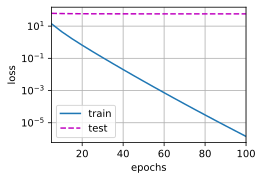

In [45]:
train(0)

从图中我们可以看出，训练集损失下降，但是测试集损失基本不变，发生了严重的过拟合问题。

#### 使用正则化进行训练

w的l2范数是： 0.3743981719017029


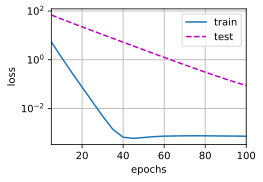

In [57]:
train(3)

这里我们将正则化参数设置为10，从图中可以看出，和之前不进行正则化训练的过程相比，过拟合情况得到了一定的缓解，测试集的损失也开始下降

## 简洁实现

由于权重衰减在神经网络中常用，深度学习框架为了便于我们使用权重衰减，将权重衰减集成到优化算法中，以便与任何损失函数结合使用。此外，这种集成还有计算上的好处，允许在不增加任何额外的计算开销的情况下向算法中添加权重衰减。由于更新的权重衰减部分仅依赖于每个参数的当前值，因此优化器必须至少接触每个参数一次。

在下面的代码中，我们在实例化优化器时直接通过weight_decay指定weight decay超参数。

默认情况下，Pytorch同时衰减权重和偏移。这里我们只为权重设置了weight_decay，所以偏置参数b不会衰减。

In [58]:
def train_concise(wd):
    net = nn.Sequential(nn.Linear(num_inputs, 1))
    for param in net.parameters():
        param.data.normal_()
    loss = nn.MSELoss(reduction='none')
    num_epochs, lr = 100, 0.003
    # 偏置参数没有衰减
    trainer = torch.optim.SGD([
        {"params": net[0].weight, 'weight_decay': wd},
        {"params": net[0].bias}
    ], lr=lr)
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[5, num_epochs], legend=['train', 'test'])
    for epoch in range(num_epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.mean().backward()
            trainer.step()
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1,
                         (d2l.evaluate_loss(net, train_iter, loss),
                          d2l.evaluate_loss(net, test_iter, loss)))
    print('w的l2范数是：', net[0].weight.norm().item())

### 不使用权重衰减

w的l2范数是： 14.369256973266602


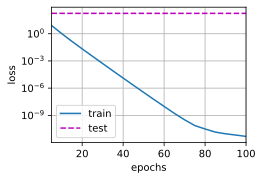

In [59]:
train_concise(0)

### 使用权重衰减

w的l2范数是： 0.44569575786590576


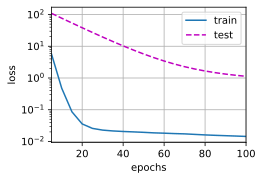

In [60]:
train_concise(3)

# 暂退法（Dropout）

在前面我们介绍了通过惩罚项权重的$L_2$范数来正则化统计模型的经典方法。在概率角度看，我们可以通过以下论证来证明这一技术的合理性：我们已经假设了一个先验，即权重的值取自均值为0的高斯分布。更直观的时，我们希望模型深度挖掘特征，即将其权重分散到许多特征中，而不是过于依赖少数潜在的虚假关联。

神经网络的过拟合与每一层都依赖于前一层激活值相关，称这种情况为“共适应性”，暂退法会破坏共适应性。

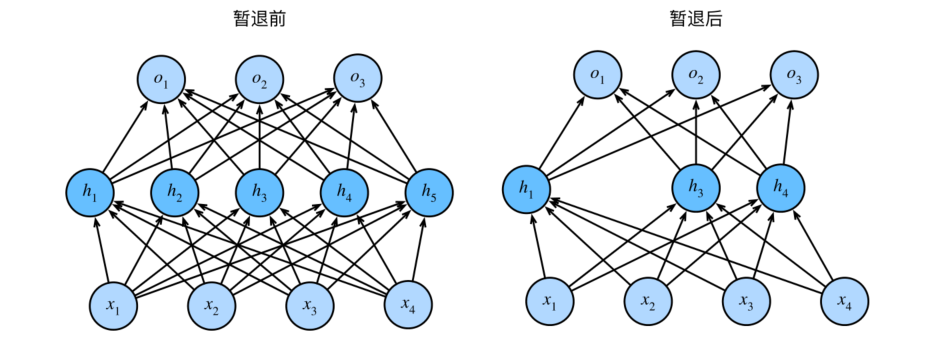

删除了$h_2$和$h_5$，因此输出的计算不再依赖于$h_2$或$h_5$，并且它们各⾃的梯度在执⾏反向传播时也会消失。这样，输出层的计算不能过度依赖于$h_1$,$\ldots$,$h_5$的任何⼀个元素。<br>
⼀些研究⼈员在测试时使⽤暂退法，⽤于估计神经⽹络预测的“不确定性”：如果通过许多不同的暂退法遮盖后得到的预测结果都是⼀致的，那么我们可以说⽹络发挥更稳定。

## 从零开始实现

### 定义Dropout函数

In [61]:
import torch
from torch import nn
from d2l import torch as d2l


def dropout_layer(X, dropout):
    assert 0 <= dropout <= 1, 'dropout值必须在0~1之间'
    # 在本情况中，所有元素都被丢弃
    if dropout == 1:
        return torch.zeros_like(X)
    # 在本情况中，所有元素都被保留
    if dropout == 0:
        return X
    mask = (torch.rand(X.shape) > dropout).float()
    return mask * X / (1.0 - dropout)

我们可以通过下面几个例子来测试dropout_layer函数。我们将输入X通过暂退法操作，暂退概率分别为0、0.5和1。

In [62]:
X = torch.arange(16, dtype = torch.float32).reshape((2, 8))
X

tensor([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11., 12., 13., 14., 15.]])

In [74]:
print(dropout_layer(X, 0.))
print('-'*50)
print(dropout_layer(X, 0.5))
print('-'*50)
print(dropout_layer(X, 1.))
print('-'*50)

tensor([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11., 12., 13., 14., 15.]])
--------------------------------------------------
tensor([[ 0.,  2.,  0.,  0.,  8.,  0., 12.,  0.],
        [16.,  0., 20.,  0., 24., 26., 28., 30.]])
--------------------------------------------------
tensor([[0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.]])
--------------------------------------------------


### 定义模型参数

In [75]:
num_inputs, num_outputs, num_hiddens1, num_hiddens2 = 784, 10, 256, 256

### 定义模型

我们可以将暂退法应⽤于每个隐藏层的输出（在激活函数之后），并且可以为每⼀层分别设置暂退概率：常⻅的技巧是在靠近输⼊层的地⽅设置较低的暂退概率。下面的模型将第一个和第二个隐藏层的暂退概率分别设置为0.2和0.5，并且暂退法只在训练期间有效。

In [78]:
dropout1, dropout2 = 0.2, 0.5

class Net(nn.Module):
    def __init__(self, num_inputs, num_outputs, num_hiddens1, num_hiddens2,
                is_training=True):
        super(Net, self).__init__()
        self.num_inputs = num_inputs
        self.training = is_training
        self.lin1 = nn.Linear(num_inputs, num_hiddens1)
        self.lin2 = nn.Linear(num_hiddens1, num_hiddens2)
        self.lin3 = nn.Linear(num_hiddens2, num_outputs)
        self.relu = nn.ReLU()
    
    def forward(self, X):
        H1 = self.relu(self.lin1(X.reshape((-1, self.num_inputs))))
        # 只有在训练模型时才使用dropout
        if self.training == True:
            # 在第一个全连接层之后添加一个dropout层
            H1 = dropout_layer(H1, dropout1)
        H2 = self.relu(self.lin2(H1))
        if self.training == True:
            # 在第二个全连接层之后添加一个dropout层
            H2 = dropout_layer(H2, dropout2)
        out = self.lin3(H2)
        return out

In [79]:
net = Net(num_inputs, num_outputs, num_hiddens1, num_hiddens2)

### 训练和测试

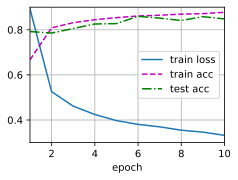

In [80]:
num_epochs, lr, batch_size = 10, 0.5, 256
loss = nn.CrossEntropyLoss(reduction='none')
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
trainer = torch.optim.SGD(net.parameters(), lr=lr)
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

## 简洁实现

In [82]:
net = nn.Sequential(nn.Flatten(),
                    nn.Linear(784, 256),
                    nn.ReLU(),
                    # 在第一个全连接层之后添加一个dropout层
                    nn.Dropout(dropout1),
                    nn.Linear(256, 256),
                    nn.ReLU(),
                    # 在第二个全连接之后添加一个dropout层
                    nn.Dropout(dropout2),
                    nn.Linear(256, 10)
                   )
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)
net.apply(init_weights)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): ReLU()
  (3): Dropout(p=0.2, inplace=False)
  (4): Linear(in_features=256, out_features=256, bias=True)
  (5): ReLU()
  (6): Dropout(p=0.5, inplace=False)
  (7): Linear(in_features=256, out_features=10, bias=True)
)

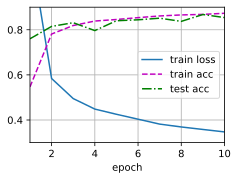

In [83]:
trainer = torch.optim.SGD(net.parameters(), lr=lr)
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

课件模型的过拟合程度进一步减轻

# 前向传播、反向传播和计算图

## 前向传播

前向传播（forward）：指的是按顺序（从输入层到输出层）计算和存储神经网络中每层的结果。<br>
假设输入样本是$\mathbf{x}\in\mathbb{R}^d$，并且我们的隐藏层不包括偏置项。这里的中间变量是：
$$
\mathbf{z} = \mathbf{W}^{(1)}\mathbf{x},\tag{1}
$$

其中$\mathbf{W}^{(1)}\in\mathbb{R}^{h\times d}$是隐藏层的权重参数。将中间变量$\mathbf{z}\in\mathbb{R}^h$通过激活函数$\phi$后，我们得到长度为h的隐藏激活向量：
$$
\mathbf{h}=\phi(\mathbf{z}).\tag{2}
$$

隐藏变量$\mathbf{h}$也是一个中间变量。假设输出层的参数只有权重$\mathbf{W}^{(2)}\in\mathbb{R}^{q \times h}$，我们可以得到输出层变量，它是一个长度为q的向量：
$$
\mathbf{o}=\mathbf{W}^{(2)}\mathbf{h}.\tag{3}
$$

假设损失函数为$l$，样本标签为$y$，我们可以计算单个数据样本的损失项，
$$
L=l(\mathbf{o}, y).\tag{4}
$$

根据$L_2$正则化的定义，给定超参数$\lambda$，正则化项为
$$
s = \frac{\lambda}{2}(\Vert \mathbf{W}^{(1)} \Vert^2_F + \Vert \mathbf{W}^{(2)} \Vert^2_F),\tag{5}
$$

其中矩阵的`Frobenius`范数是将矩阵展品为向量后应用的$L_2$范数。最后，模型在给定数据样本上的正则化损失为：
$$
J = L + s.\tag{6}
$$

在下面的讨论中，我们将J称为目标函数。

## 反向传播

反向传播（backward）指的是计算神经网络参数梯度的方法。简言之，该方法根据微积分中的链式法则，按相反的顺序从输出层到输入层遍历网络。该算法存储了计算某些参数梯度时所需的任何中间变量（偏导数）。假设我们有函数$Y=f(x)$和$Z=g(x)$，其中输入和输出$X,Y,Z$是任意形状的张量。利用链式法则，我们可以计算Z关于X的导数

$$
\frac{\partial{Z}}{\partial{X}}=prod(\frac{\partial{Z}}{\partial{Y}}, \frac{\partial{Y}}{\partial{X}}).\tag{7}
$$

回想一下，在计算图中的单层隐藏层简单网络的参数是$\mathbf{W}^{(1)}$和$\mathbf{W}^{(2)}$

反向传播的目的是计算梯度$\partial{J}/\partial{\mathbf{W}^{(1)}}$和$\partial{J}/\partial{\mathbf{W}^{(2)}}$。

为此我们应用链式法则，依次计算每个中间变量和参数的梯度。计算的顺序于前向传播中执行的顺序相反，因为我们需要从计算图的结果开始，并朝着参数的方向努力。第一步是计算目标函数$J=L + s$相对于损失函数L和正则项s的梯度。
$$
\frac{\partial{J}}{\partial{L}}=1\quad and \quad \frac{\partial{J}}{\partial{s}}=1
$$

接下来，我们根据链式法则计算目标函数关于输出层变量$\mathbf{o}$的梯度：
$$
\frac{\partial J}{\partial \mathbf{o}}=\operatorname{prod}\left(\frac{\partial J}{\partial L}, \frac{\partial L}{\partial \mathbf{o}}\right)=\frac{\partial L}{\partial \mathbf{o}} \in \mathbb{R}^{q}
$$

接下来我们计算正则化项相对于两个参数的梯度：
$$
\frac{\partial s}{\partial \mathbf{W}^{(1)}}=\lambda \mathbf{W}^{(1)} \text { and } \frac{\partial s}{\partial \mathbf{W}^{(2)}}=\lambda \mathbf{W}^{(2)}
$$

现在我们可以计算最接近输出层的模型参数的梯度$\partial J / \partial \mathbf{W}^{(2)} \in \mathbb{R}^{q \times h}$。使用链式法则得出：
$$
\frac{\partial J}{\partial \mathbf{W}^{(2)}}=\operatorname{prod}\left(\frac{\partial J}{\partial \mathbf{o}}, \frac{\partial \mathbf{o}}{\partial \mathbf{W}^{(2)}}\right)+\operatorname{prod}\left(\frac{\partial J}{\partial s}, \frac{\partial s}{\partial \mathbf{W}^{(2)}}\right)=\frac{\partial J}{\partial \mathbf{o}} \mathbf{h}^{\top}+\lambda \mathbf{W}^{(2)}
$$

为了获得关于$\mathbf{W}^{(1)}$的梯度，我们需要继续沿着输出层到隐藏层反向传播。关于隐藏层输出的梯度$\partial{J}/\partial{\mathbf{h}}\in\mathbb{R}^{h}$由下式给出：
$$
\frac{\partial{j}}{\partial{\mathbf{h}}}=prod(\frac{\partial{j}}{\partial{\mathbf{o}}}, \frac{\partial{\mathbf{o}}}{\partial{\mathbf{h}}})={\mathbf{W}^{(2)}}^\top \frac{\partial{J}}{\partial{\mathbf{o}}}
$$

由于激活函数$\phi$是按元素计算的，计算中间变量$\mathbf{z}$的梯度$\partial{J}/\partial{\mathbf{z}}\in\mathbb{R}^h$需要使用按元素乘法运算符，我们用$\odot$表示：

$$
\frac{\partial J}{\partial \mathbf{z}}=\operatorname{prod}\left(\frac{\partial J}{\partial \mathbf{h}}, \frac{\partial \mathbf{h}}{\partial \mathbf{z}}\right)=\frac{\partial J}{\partial \mathbf{h}} \odot \phi^{\prime}(\mathbf{z})
$$

最后我们可以得到最接近输入层的模型参数的梯度$\partial{J}/\partial{\mathbf{W}^{(1)}}\in\mathbb{R}^{h\times d}$。根据链式法则，我们得到：
$$
\frac{\partial J}{\partial \mathbf{W}^{(1)}}=\operatorname{prod}\left(\frac{\partial J}{\partial \mathbf{z}}, \frac{\partial \mathbf{z}}{\partial \mathbf{W}^{(1)}}\right)+\operatorname{prod}\left(\frac{\partial J}{\partial s}, \frac{\partial s}{\partial \mathbf{W}^{(1)}}\right)=\frac{\partial J}{\partial \mathbf{z}} \mathbf{x}^{\top}+\lambda \mathbf{W}^{(1)}
$$

## 训练神经网络

在训练神经⽹络时，前向传播和反向传播相互依赖。对于前向传播，我们沿着依赖的⽅向遍历计算图并计算其路径上的所有变量。然后将这些⽤于反向传播，其中计算顺序与计算图的相反。

# 数值稳定性和模型初始化

到⽬前为⽌，我们实现的每个模型都是根据某个预先指定的分布来初始化模型的参数。你可能认为初始化⽅案是理所当然的，忽略了如何做出这些选择的细节。你甚⾄可能会觉得，初始化⽅案的选择并不是特别重要。相反，初始化⽅案的选择在神经⽹络学习中起着举⾜轻重的作⽤，它对保持数值稳定性⾄关重要。

此外，这些初始化⽅案的选择可以与⾮线性激活函数的选择有趣的结合在⼀起。我们选择哪个函数以及如何初始化参数可以决定优化算法收敛的速度有多快。糟糕选择可能会导致我们在训练时遇到梯度爆炸或梯度消失。

## 梯度爆炸和梯度消失

- 梯度消失（gradient vanishing）问题：参数更新过⼩，在每次更新时⼏乎不会移动，导致模型⽆法学习。
- 梯度爆炸（gradient exploding）问题：参数更新过⼤，破坏了模型的稳定收敛；

### 梯度消失

曾经sigmoid函数1/(1 + exp(−x))（4.1节提到过）很流⾏，因为它类似于阈值函数。由于早期的⼈⼯神经⽹络受到⽣物神经⽹络的启发，神经元要么完全激活要么完全不激活（就像⽣物神经元）的想法很有吸引⼒。
然⽽，它却是导致梯度消失问题的⼀个常⻅的原因，让我们仔细看看sigmoid函数为什么会导致梯度消失。

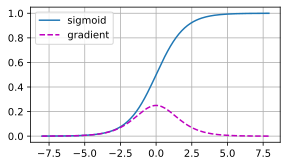

In [85]:
%matplotlib inline
import torch
from d2l import torch as d2l
x = torch.arange(-8.0, 8.0, 0.1, requires_grad=True)
y = torch.sigmoid(x)
y.backward(torch.ones_like(x))
d2l.plot(x.detach().numpy(), [y.detach().numpy(), x.grad.numpy()],
         legend=['sigmoid', 'gradient'], figsize=(4.5, 2.5))

正如我们所看到的，当sigmoid函数的输入很大或是很小时，它的梯度都会消失。此外，当反向传播通过许多层时，除非我们在刚刚好的地方，这些地方sigmoid函数的输入接近于零，否则整个乘积的梯度可能会消失。当我们的网络有很多层时，除非我们很小心，否则在某一层可能会切断梯度。事实上，这个问题曾经困扰着深度网络的训练。因此，更稳定的ReLU系列函数以及成为从业者的默认选择。

### 梯度爆炸

相反，梯度爆炸可能同样令人烦恼。为了更好地说明这一点，我们生成100个高斯随机矩阵，并将它们于某个初始矩阵相乘。对于我们选择的尺度（方差$\sigma^2=1$）,矩阵乘积发生爆炸。当这种情况是由于深度网络的初始化所导致时，我们没有机会让梯度下降优化器收敛。

In [86]:
M = torch.normal(0, 1, size=(4,4))
print('⼀个矩阵 \n',M)
for i in range(100):
    M = torch.mm(M,torch.normal(0, 1, size=(4, 4)))
print('乘以100个矩阵后\n', M)

⼀个矩阵 
 tensor([[-0.8096, -0.7782, -0.2406, -0.7807],
        [ 0.3637,  0.1612, -0.2227,  0.8145],
        [ 1.0566, -0.4697, -0.9057, -0.8289],
        [-0.6465,  0.5376, -1.1364,  0.3843]])
乘以100个矩阵后
 tensor([[-2.5868e+27, -1.0076e+27, -2.8457e+27, -5.1784e+27],
        [ 2.4840e+27,  9.6753e+26,  2.7327e+27,  4.9727e+27],
        [-1.3921e+27, -5.4223e+26, -1.5315e+27, -2.7868e+27],
        [ 1.6945e+27,  6.6002e+26,  1.8642e+27,  3.3922e+27]])


### 打破对称性

神经⽹络设计中的另⼀个问题是其参数化所固有的对称性。假设我们有⼀个简单的多层感知机，它有⼀个隐藏层和两个隐藏单元。在这种情况下，我们可以对第⼀层的权重$\mathbf{W}^{(1)}$ 进⾏重排列，并且同样对输出层的权重进⾏重排列，可以获得相同的函数。第⼀个隐藏单元与第⼆个隐藏单元没有什么特别的区别。换句话说，我们在每⼀层的隐藏单元之间具有排列对称性。

假设输出层将上述两个隐藏单元的多层感知机转换为仅⼀个输出单元。想象⼀下，如果我们将隐藏层的所有参数初始化为$\mathbf{W}^{(1)}=c$，c为常量，会发⽣什么？在这种情况下，在前向传播期间，两个隐藏单元采⽤相同的输⼊和参数，产⽣相同的激活，该激活被送到输出单元。在反向传播期间，根据参数$\mathbf{W}^{(1)}$对输出单元进⾏微分，得到⼀个梯度，其元素都取相同的值。因此，在基于梯度的迭代（例如，⼩批量随机梯度下降）之后，$\mathbf{W}^{(1)}$的所有元素仍然采⽤相同的值。这样的迭代永远不会打破对称性，我们可能永远也⽆法实现⽹络的表达能⼒。隐藏层的⾏为就好像只有⼀个单元。请注意，虽然⼩批量随机梯度下降不会打破这种对称性，但**暂退法、正则化**可以。

## 参数初始化

解决（或至少减轻）上述问题的一种方法是进行参数初始化，优化期间的注意和适当的正则化也可以进一步提高稳定性。

### 默认初始化

在前面的部分中，我们使用**正态分布**来初始化权重值。如果我们不指定初始化方法，框架将使用**默认的随机初始化方法**，对于中等难度的问题，这种方法通常很有效。

### Xavier初始化

In [95]:
torch.nn.init.xavier_normal_(torch.empty(3, 5))

tensor([[ 0.4064,  1.0027,  0.5192, -0.0838, -0.9172],
        [ 0.2655, -0.3343, -1.1101,  1.1963,  0.4771],
        [ 0.0231, -0.1928, -0.6812, -0.6417, -0.6339]])